# Machine Learning Project -1   (Linear Regression)
 
## Problem Statement : 

One of the largest retail chains in the world wants to use their vast data source to **build an efficient forecasting model to predict the sales for each SKU(stock-keeping unit) in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis.** Sales and promotional information is also available for each week - product and store wise. 

However, no other information regarding stores and products are available. So **we need to forecast accurately the sales values for every such product/SKU-store combination for the next 12 weeks accurately.**
## Data Description

Variable | Definition

`record_ID           | Unique ID for each week store sku combination
week                 | Starting Date of the week
store_id             | Unique ID for each store (no numerical order to be assumed)
sku_id               | Unique ID for each product (no numerical order to be assumed)
total_price          | Sales Price of the product
base_price           | Base price of the product
is_featured_sku      | Was part of the featured item of the week
is_display_sku       | Product was on display at a prominent place at the store
units_sold           | (Target) Total Units sold for that week-store-sku combination`

## Evaluation Metric
The evaluation metric is 100*RMSLE (Root Mean Squared Log Error).

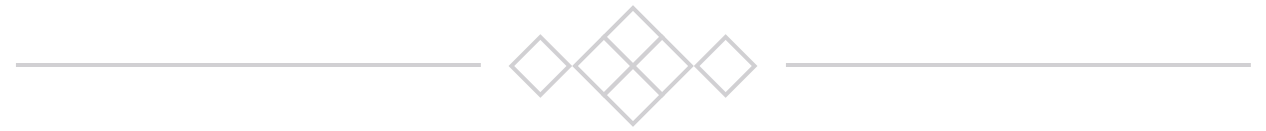

In [1]:
'''Importing Important Libraires'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r"C:\Users\YashnaBehera\Downloads\train_0irEZ2H.csv")
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [3]:
test = pd.read_csv(r"C:\Users\YashnaBehera\Downloads\test_nfaJ3J5.csv")
test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


In [4]:
print(f"THe number of rows in the train data are \033[1m{train.shape[0]}\033[0m whereas in the test data are \033[1m{test.shape[0]}\033[0m"
     f"\nThe total Number of features given in the data are train.shape{1}.")

THe number of rows in the train data are 150150 whereas in the test data are 13860
The total Number of features given in the data are train.shape1.


In the given problem statement, **units_sold** is the target variable, which we will predict using the regression models.

In [5]:
train.dtypes

record_ID            int64
week                object
store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku       int64
units_sold           int64
dtype: object

From the above dtypes, we see that majority of the columns are of numerical data type. *`record_ID`* is the unique identification number as mentioned in the data description. So we can remove it from the datasets (both training and testing). *`week`* is a datetime datatype, which is given as an object. We typecast it to datetime datatype. *`is_featured_sku`* and *`is_display_sku`* are categorical features. *`store_id`* and *`sku_id`* are both unique ids for the stores and products respectively. Both of these features are categorical as well.

In [6]:
# making a copy of train and test data
ds1 = train.copy()
ds1.drop(['record_ID'], axis = 1, inplace = True)

ds2 = test.copy()
ds2.drop(['record_ID'], axis = 1, inplace = True)

# Typecasting of the features
ds1['week'] = pd.to_datetime(ds1['week'])
ds2['week'] = pd.to_datetime(ds2['week'])

ds1['store_id'] = ds1['store_id'].astype('category')
ds2['store_id'] = ds2['store_id'].astype('category')

ds1['sku_id'] = ds1['sku_id'].astype('category')
ds2['sku_id'] = ds2['sku_id'].astype('category')

ds1['is_featured_sku'] = ds1['is_featured_sku'].astype('category')
ds2['is_featured_sku'] = ds2['is_featured_sku'].astype('category')

ds1['is_display_sku'] = ds1['is_display_sku'].astype('category')
ds2['is_display_sku'] = ds2['is_display_sku'].astype('category')

### New Columns Formation:
We see that the *`week`* feature has been given to us. We will use it to make new features which would be helpful for the EDA and the model building.
    
`Day of the week
Week of the Month
Month of the Year`

We will also make a column Discount after substracting the *`base_price`* and *`total_price`*.

In [7]:
def week_of_month(n):
    from calendar import Calendar
    cal = Calendar() # week starts Monday
    #cal = Calendar(6) # week stars Sunday

    weeks = cal.monthdayscalendar(n.year, n.month)
    for x in range(len(weeks)):
        if n.day in weeks[x]:
            return x+1

In [8]:
ds1_dow = ds1['week'].dt.day_name()
ds2_dow = ds2['week'].dt.day_name()

ds1_doy = ds1['week'].dt.dayofyear
ds2_doy = ds2['week'].dt.dayofyear

ds1_moy = ds1['week'].dt.month
ds2_moy = ds2['week'].dt.month

ds1_woy = ds1['week'].dt.strftime('%W')
ds1_woy = ds1_woy.astype('int')
ds2_woy = ds2['week'].dt.strftime('%W')
ds2_woy = ds2_woy.astype('int')

ds1_wom = ds1['week'].apply(lambda x: week_of_month(x))
ds2_wom = ds2['week'].apply(lambda x: week_of_month(x))

In [9]:
# Adding columns in train data
ds1['dow'] = ds1_dow
ds1['doy'] = ds1_doy

ds1['wom'] = ds1_wom
ds1['woy'] = ds1_woy

ds1['moy'] = ds1_moy

# adding columns in the test data
ds2['dow'] = ds2_dow
ds2['doy'] = ds2_doy

ds2['wom'] = ds2_wom
ds2['woy'] = ds2_woy

ds2['moy'] = ds2_moy

In [10]:
ds1_year = ds1['week'].dt.year
ds2_year = ds2['week'].dt.year

ds1['Year'] = ds1_year
ds2['Year'] = ds2_year

In [11]:
ds1.drop(['week', 'Year'], axis = 1, inplace = True)
ds2.drop(['week', 'Year'], axis = 1, inplace = True)

In [12]:
ds1.tail()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,dow,doy,wom,woy,moy
150145,9984,223245,235.8375,235.8375,0,0,38,Saturday,250,2,35,9
150146,9984,223153,235.8375,235.8375,0,0,30,Saturday,250,2,35,9
150147,9984,245338,357.6750,483.7875,1,1,31,Saturday,250,2,35,9
150148,9984,547934,141.7875,191.6625,0,1,12,Saturday,250,2,35,9
150149,9984,679023,234.4125,234.4125,0,0,15,Saturday,250,2,35,9


In [13]:
def UVA_category(data, var_group):
  # setting figure_size
  plt.figure(figsize = (10,3), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True)*100
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    sns.barplot(norm_count, norm_count.index , order = norm_count.index, palette="Blues_d")
    plt.xlabel('fraction/percent', fontsize = 20)
    plt.ylabel('{}'.format(i), fontsize = 20)
    plt.style.use('seaborn-white')
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))


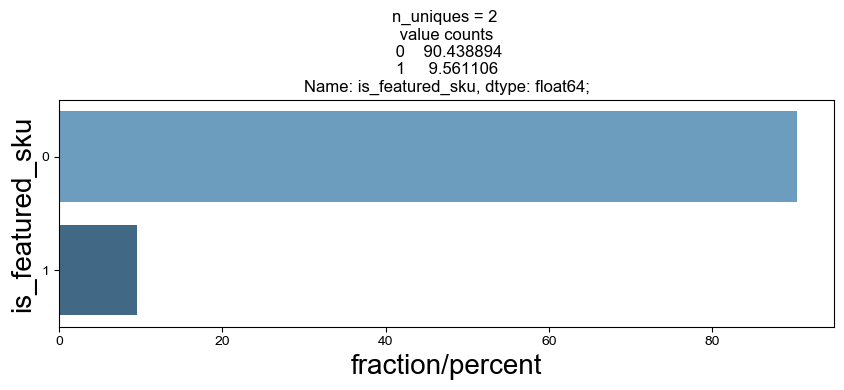

In [14]:
UVA_category(ds1,["is_featured_sku"])

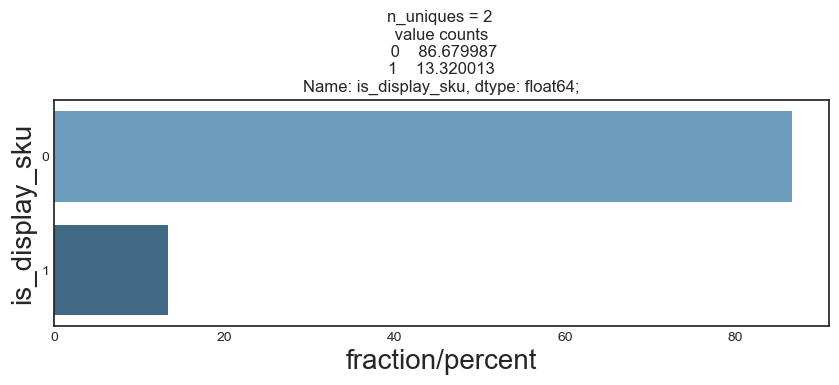

In [15]:
UVA_category(ds1,["is_display_sku"])
#ds1["is_display_sku"].value_counts().plot(kind="bar",cmap="tab20c", rot=0)

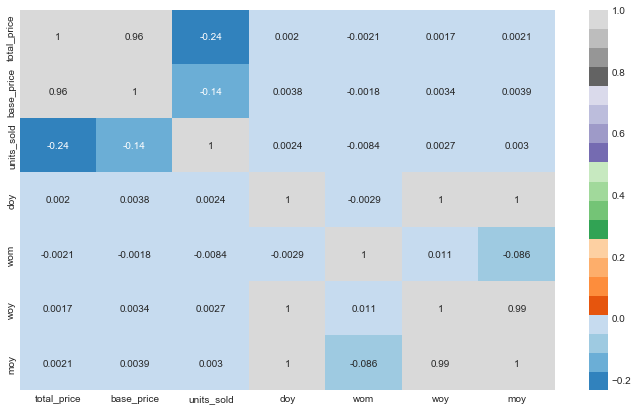

In [16]:
plt.figure(figsize = (12, 7))
plt.style.use('seaborn-white')
sns.heatmap(ds1.corr(), annot = True,cmap="tab20c")
plt.show()

In [17]:
most_sells_by_month = ds1.groupby(['moy'])['units_sold'].sum().sort_values(ascending = False).reset_index()
most_sells_by_month

,moy,units_sold
0,5,869648
1,2,862412
2,1,702747
3,6,690137
4,11,651667
5,4,643915
6,3,615777
7,12,595525
8,8,570992
9,7,535454


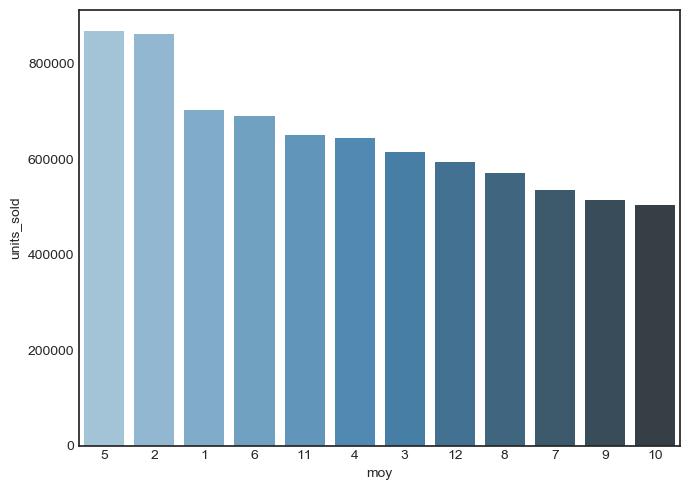

In [18]:
plt.figure(figsize = (7,5), dpi = 100)
plt.style.use('seaborn-white')
sns.barplot(data = most_sells_by_month, y = 'units_sold', 
            x = 'moy', palette="Blues_d", order = most_sells_by_month.sort_values('units_sold', ascending = False).moy)
plt.tight_layout()

In [19]:
most_sells_by_day = ds1.groupby(['dow'])['units_sold'].sum().sort_values(ascending = False).reset_index()
most_sells_by_day

,dow,units_sold
0,Monday,3285968
1,Tuesday,2491504
2,Thursday,620832
3,Sunday,436867
4,Saturday,378230
5,Friday,335315
6,Wednesday,210166


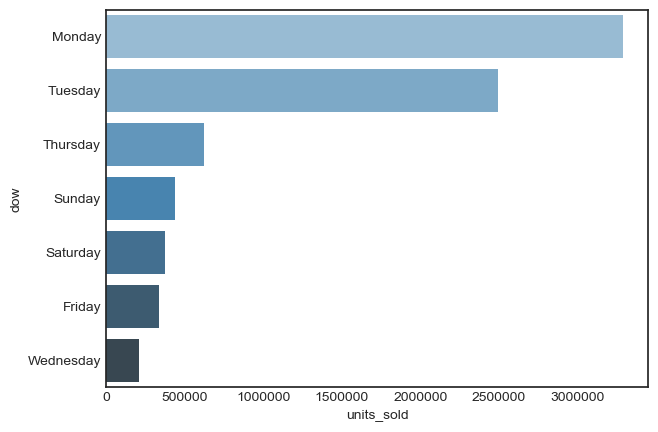

In [20]:
plt.figure(figsize = (7,5), dpi = 100)
plt.style.use('seaborn-white')
sns.barplot(data = most_sells_by_day, x = 'units_sold', 
            y = 'dow', palette="Blues_d" ,order = most_sells_by_day.sort_values('units_sold', ascending = False).dow)

In [21]:
most_sells_by_week = ds1.groupby(['wom'])['units_sold'].sum().sort_values(ascending = False).reset_index()
most_sells_by_week

,wom,units_sold
0,4,1833170
1,5,1736586
2,3,1503386
3,2,1321513
4,1,1100535
5,6,263692


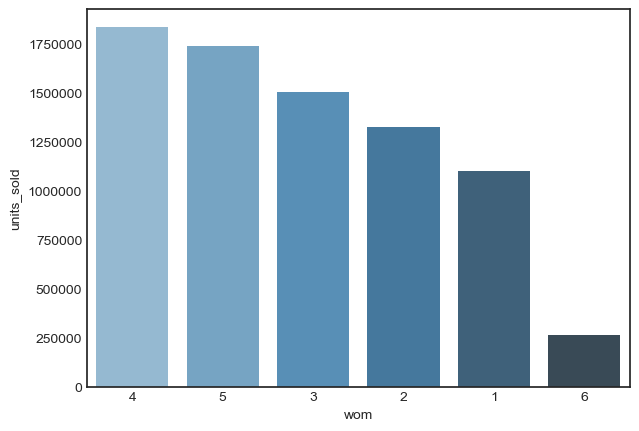

In [22]:
plt.figure(figsize = (7,5), dpi = 100)
plt.style.use('seaborn-white')
sns.barplot(data = most_sells_by_week, y = 'units_sold', 
            x = 'wom', palette="Blues_d" ,order = most_sells_by_week.sort_values('units_sold', ascending = False).wom)

In [23]:
ds1.drop(['woy', 'doy'], axis = 1, inplace = True)
ds2.drop(['woy', 'doy'], axis = 1, inplace = True)

In [24]:
ds1.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,dow,wom,moy
0,8091,216418,99.0375,111.8625,0,0,20,Monday,4,1
1,8091,216419,99.0375,99.0375,0,0,28,Monday,4,1
2,8091,216425,133.9500,133.9500,0,0,19,Monday,4,1
3,8091,216233,133.9500,133.9500,0,0,44,Monday,4,1
4,8091,217390,141.0750,141.0750,0,0,52,Monday,4,1


In [25]:
most_sells_by_store = ds1.groupby(['store_id'])['units_sold'].sum().sort_values(ascending = False).reset_index()
most_sells_by_store[:20]

,store_id,units_sold
0,8023,296478
1,9845,261410
2,9823,233846
3,9112,218127
4,9613,205710
5,8222,197509
6,9611,196565
7,8095,191277
8,9250,168072
9,9961,156392


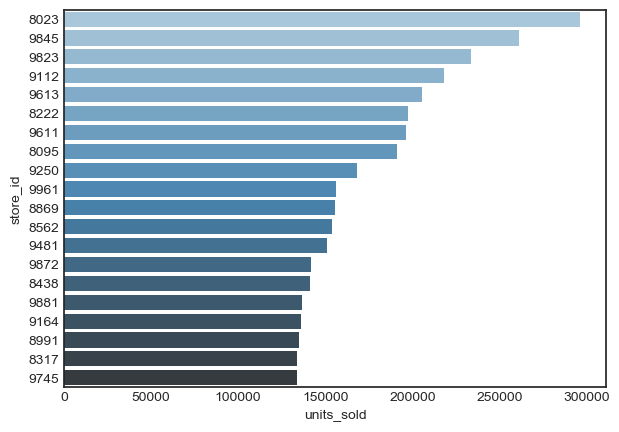

In [26]:
plt.figure(figsize = (7,5), dpi = 100)
plt.style.use('seaborn-white')
sns.barplot(data = most_sells_by_store[:20], x = 'units_sold', 
            y = 'store_id', palette="Blues_d" ,order = most_sells_by_store[:20].sort_values('units_sold', ascending = False).store_id)

In [27]:
most_sells_by_sku = ds1.groupby(['sku_id'])['units_sold'].sum().sort_values(ascending = False).reset_index()
most_sells_by_sku

,sku_id,units_sold
0,219009,964194
1,216418,786087
2,223245,650165
3,216419,628711
4,222087,601228
5,217390,567046
6,222765,478596
7,223153,455473
8,219029,450563
9,216233,450420


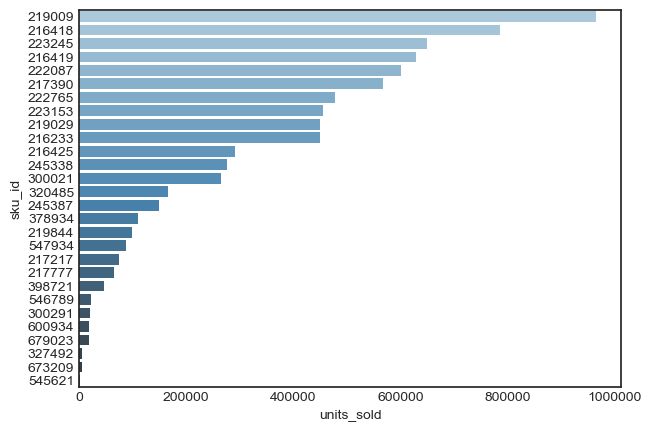

In [28]:
plt.figure(figsize = (7,5), dpi = 100)
plt.style.use('seaborn-white')
sns.barplot(data = most_sells_by_sku, x = 'units_sold', 
            y = 'sku_id', palette="Blues_d" ,order = most_sells_by_sku.sort_values('units_sold', ascending = False).sku_id)

In [29]:
most_sold = [219009, 216418, 223245]
least_sold = [545621, 673209, 327492]

In [30]:
ds1[ds1['sku_id'].isin(most_sold)]['is_featured_sku'].value_counts()

0    25730
1     2350
Name: is_featured_sku, dtype: int64

In [31]:
(2350/(25730 + 2350))*100

8.36894586894587

In [32]:
ds1[ds1['sku_id'].isin(least_sold)]['is_featured_sku'].value_counts()

0    618
1     32
Name: is_featured_sku, dtype: int64

In [33]:
(32/(618 + 32))*100

4.923076923076923

In [34]:
ds1[ds1['sku_id'].isin(most_sold)]['is_display_sku'].value_counts()

0    23315
1     4765
Name: is_display_sku, dtype: int64

In [35]:
(4765/(23315 + 4765))*100

16.969373219373217

In [36]:
ds1[ds1['sku_id'].isin(least_sold)]['is_display_sku'].value_counts()

0    589
1     61
Name: is_display_sku, dtype: int64

In [37]:
(61/(589 + 61))*100

9.384615384615385

In [38]:
details = {
    'Items' : ['Most Sold', 'Least Sold'],
    'featured%' : [8.36, 4.92],
    'displayed%' : [16.96,9.38],
}
  
# creating a Dataframe object 
demo_df = pd.DataFrame(details)
  
demo_df

,Items,featured%,displayed%
0,Most Sold,8.36,16.96
1,Least Sold,4.92,9.38


<Figure size 700x500 with 0 Axes>

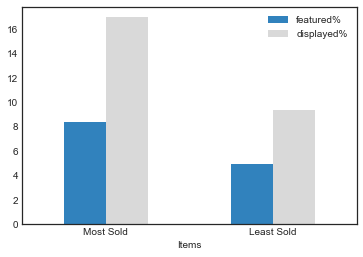

In [39]:
plt.figure(figsize = (7,5), dpi = 100)
plt.style.use('seaborn-white')
demo_df.plot(x="Items",y=["featured%","displayed%"],kind="bar",cmap="tab20c", rot=0)

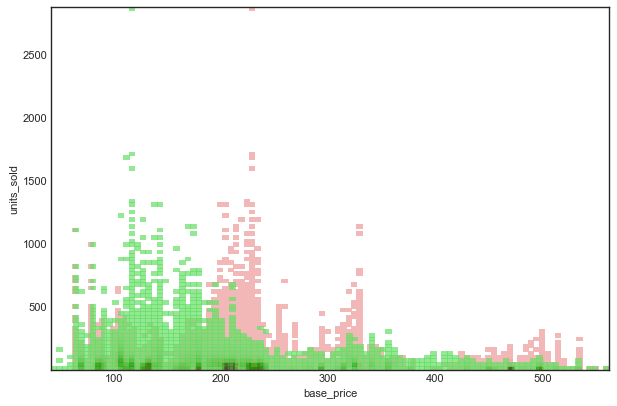

In [40]:
plt.figure(figsize = (9, 6), dpi = 80)
sns.histplot(y="units_sold", x= "base_price",data=ds1, bins = 100, color = "r")
sns.histplot(y="units_sold", x= "total_price",data=ds1, bins = 100, alpha = 0.7, color = "g")
plt.show()

# Removing Outliers

In [41]:
quant25 = ds1["base_price"].quantile(0.25)
quant75 = ds1["base_price"].quantile(0.75)
IQR = quant75 - quant25
med = ds1["base_price"].median()
whis_high = med+(1.5*IQR)
whis_high

357.67499999999995

In [42]:
out_rem_bp_train = ds1[ds1['base_price'] < 380]
out_rem_bp_train.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,dow,wom,moy
0,8091,216418,99.0375,111.8625,0,0,20,Monday,4,1
1,8091,216419,99.0375,99.0375,0,0,28,Monday,4,1
2,8091,216425,133.9500,133.9500,0,0,19,Monday,4,1
3,8091,216233,133.9500,133.9500,0,0,44,Monday,4,1
4,8091,217390,141.0750,141.0750,0,0,52,Monday,4,1


In [43]:
ds1['base_price'].isnull().sum()

0

In [44]:
ds1['base_price'] = out_rem_bp_train['base_price']
ds1['base_price'].isnull().sum()

17123

In [45]:
base_price_mean = ds1.pivot_table(values='base_price', columns='sku_id', aggfunc='mean')
base_price_mean

sku_id,216233,216418,216419,216425,217217,217390,217777,219009,219029,219844,...,320485,327492,378934,398721,545621,546789,547934,600934,673209,679023
base_price,128.101871,94.688268,94.908763,128.28521,241.532862,158.990538,237.607788,208.554815,314.075856,256.099512,...,204.829984,127.046971,204.436294,356.0125,352.660096,208.00772,174.616247,376.9125,352.75601,209.117532


In [46]:
# replacing the null values with the mean of 'item_weight_mean'
loc1 = ds1['base_price'].isnull()
ds1.loc[loc1, 'base_price'] = ds1.loc[loc1, 'sku_id'].apply(lambda x: base_price_mean[x])

TypeError: 'Series' objects are mutable, thus they cannot be hashed

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
  File "C:\Users\YashnaBehera\anaconda3\lib\site-packages\pandas\core\generic.py", line 1799, in __hash__
    f"{repr(type(self).__name__)} objects are mutable, "
TypeError: 'Series' objects are mutable, thus they cannot be hashed


In [47]:
ds1.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,dow,wom,moy
0,8091,216418,99.0375,111.8625,0,0,20,Monday,4,1
1,8091,216419,99.0375,99.0375,0,0,28,Monday,4,1
2,8091,216425,133.9500,133.9500,0,0,19,Monday,4,1
3,8091,216233,133.9500,133.9500,0,0,44,Monday,4,1
4,8091,217390,141.0750,141.0750,0,0,52,Monday,4,1


In [48]:
out_rem_bp_test = ds2[ds2['base_price'] < 380]
out_rem_bp_test.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,dow,wom,moy
0,8091,216418,108.3000,108.3000,0,0,Tuesday,3,7
1,8091,216419,109.0125,109.0125,0,0,Tuesday,3,7
2,8091,216425,133.9500,133.9500,0,0,Tuesday,3,7
3,8091,216233,133.9500,133.9500,0,0,Tuesday,3,7
4,8091,217390,176.7000,176.7000,0,0,Tuesday,3,7


In [49]:
ds2['base_price'].isnull().sum()

0

In [50]:
ds2['base_price'] = out_rem_bp_test['base_price']
ds2['base_price'].isnull().sum()

1582

In [51]:
ds2['base_price'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
13855    False
13856    False
13857     True
13858    False
13859    False
Name: base_price, Length: 13860, dtype: bool

In [52]:
# replacing the null values with the mean of 'item_weight_mean'
loc2 = ds2['base_price'].isnull()
ds2.loc[loc2, 'base_price'] = ds2.loc[loc2, 'sku_id'].apply(lambda x: base_price_mean[x])

TypeError: 'Series' objects are mutable, thus they cannot be hashed

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
  File "C:\Users\YashnaBehera\anaconda3\lib\site-packages\pandas\core\generic.py", line 1799, in __hash__
    f"{repr(type(self).__name__)} objects are mutable, "
TypeError: 'Series' objects are mutable, thus they cannot be hashed


In [53]:
ds2.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,dow,wom,moy
0,8091,216418,108.3000,108.3000,0,0,Tuesday,3,7
1,8091,216419,109.0125,109.0125,0,0,Tuesday,3,7
2,8091,216425,133.9500,133.9500,0,0,Tuesday,3,7
3,8091,216233,133.9500,133.9500,0,0,Tuesday,3,7
4,8091,217390,176.7000,176.7000,0,0,Tuesday,3,7


In [54]:
quant25 = ds1["total_price"].quantile(0.25)
quant75 = ds1["total_price"].quantile(0.75)
IQR = quant75 - quant25
med = ds1["total_price"].median()
whis_high = med+(1.5*IQR)
whis_high

353.04375

In [55]:
out_rem_tp = ds1[ds1['total_price'] < 355]
out_rem_tp.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,dow,wom,moy
0,8091,216418,99.0375,111.8625,0,0,20,Monday,4,1
1,8091,216419,99.0375,99.0375,0,0,28,Monday,4,1
2,8091,216425,133.9500,133.9500,0,0,19,Monday,4,1
3,8091,216233,133.9500,133.9500,0,0,44,Monday,4,1
4,8091,217390,141.0750,141.0750,0,0,52,Monday,4,1


In [56]:
ds1['total_price'].isnull().sum()

1

In [57]:
ds1['total_price'] = out_rem_tp['total_price']
ds1['total_price'].isnull().sum()

15211

In [58]:
total_price_mean = pd.pivot_table(data = ds1, values = 'total_price', columns = 'sku_id', aggfunc = 'mean')
total_price_mean

sku_id,216233,216418,216419,216425,217217,217390,217777,219009,219029,219844,...,320485,327492,378934,398721,545621,546789,547934,600934,673209,679023
total_price,124.942208,91.982702,92.349162,125.156355,234.481356,150.867334,232.13854,197.891577,301.903272,244.054947,...,200.293692,106.348846,200.036802,328.90168,305.425,197.927802,166.385369,319.186165,305.799519,198.309455


In [59]:
# replacing the null values with the mean of 'item_weight_mean'
loc1 = ds1['total_price'].isnull()
ds1.loc[loc1, 'total_price'] = ds1.loc[loc1, 'sku_id'].apply(lambda x: total_price_mean[x])

TypeError: 'Series' objects are mutable, thus they cannot be hashed

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
  File "C:\Users\YashnaBehera\anaconda3\lib\site-packages\pandas\core\generic.py", line 1799, in __hash__
    f"{repr(type(self).__name__)} objects are mutable, "
TypeError: 'Series' objects are mutable, thus they cannot be hashed


In [60]:
ds1.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,dow,wom,moy
0,8091,216418,99.0375,111.8625,0,0,20,Monday,4,1
1,8091,216419,99.0375,99.0375,0,0,28,Monday,4,1
2,8091,216425,133.9500,133.9500,0,0,19,Monday,4,1
3,8091,216233,133.9500,133.9500,0,0,44,Monday,4,1
4,8091,217390,141.0750,141.0750,0,0,52,Monday,4,1


In [61]:
out_rem_tp_test = ds2[ds2['total_price'] < 355]
out_rem_tp_test.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,dow,wom,moy
0,8091,216418,108.3000,108.3000,0,0,Tuesday,3,7
1,8091,216419,109.0125,109.0125,0,0,Tuesday,3,7
2,8091,216425,133.9500,133.9500,0,0,Tuesday,3,7
3,8091,216233,133.9500,133.9500,0,0,Tuesday,3,7
4,8091,217390,176.7000,176.7000,0,0,Tuesday,3,7


In [62]:
ds1['total_price'].isnull().sum()

0

In [63]:
ds2['total_price'] = out_rem_tp_test['total_price']
ds2['total_price'].isnull().sum()

1454

In [64]:
loc2 = ds2['total_price'].isnull()
ds2.loc[loc2, 'total_price'] = ds2.loc[loc2, 'sku_id'].apply(lambda x: total_price_mean[x])

TypeError: 'Series' objects are mutable, thus they cannot be hashed

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1652, in pandas._libs.hashtable.PyObjectHashTable.map_locations
  File "C:\Users\YashnaBehera\anaconda3\lib\site-packages\pandas\core\generic.py", line 1799, in __hash__
    f"{repr(type(self).__name__)} objects are mutable, "
TypeError: 'Series' objects are mutable, thus they cannot be hashed


In [65]:
ds2['total_price'].isnull().sum()

0

In [66]:
ds2['total_price'].fillna((ds2['total_price'].mean()), inplace=True)

In [67]:
ds2['total_price'].isnull().sum()

0

In [68]:
def clean_col(col):
    if(col=="Monday"):
        return 6
    elif(col=="Tuesday"):
        return 5
    elif col=="Wednesday":
        return 4
    elif col=="Thursday":
        return 3
    elif col=="Friday":
        return 2
    elif col=="Saturday":
        return 1
    else:
        return 0

In [69]:
ds1['dow']=ds1['dow'].apply(clean_col)
ds1['dow'].value_counts()

6    61215
5    49665
3    11550
1     8085
0     8085
2     6930
4     4620
Name: dow, dtype: int64

In [70]:
ds2['dow']=ds2['dow'].apply(clean_col)
ds2['dow'].value_counts()

5    9240
1    2310
4    1155
3    1155
Name: dow, dtype: int64

In [71]:
ds1.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,dow,wom,moy
0,8091,216418,99.0375,111.8625,0,0,20,6,4,1
1,8091,216419,99.0375,99.0375,0,0,28,6,4,1
2,8091,216425,133.9500,133.9500,0,0,19,6,4,1
3,8091,216233,133.9500,133.9500,0,0,44,6,4,1
4,8091,217390,141.0750,141.0750,0,0,52,6,4,1


In [72]:
ds2.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,dow,wom,moy
0,8091,216418,108.3000,108.3000,0,0,5,3,7
1,8091,216419,109.0125,109.0125,0,0,5,3,7
2,8091,216425,133.9500,133.9500,0,0,5,3,7
3,8091,216233,133.9500,133.9500,0,0,5,3,7
4,8091,217390,176.7000,176.7000,0,0,5,3,7


In [73]:
ds2.isnull().sum()

store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
dow                0
wom                0
moy                0
dtype: int64

In [74]:
y = ds1['units_sold'].copy()
x = ds1.drop(['units_sold'], axis = 1).copy()

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

max_accuracy = 0 # maximum accuracy
best_rs = 0 # best random state
for i in tqdm(range(1, 200)):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = i)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    acc = r2_score(y_test, pred)
    if acc > max_accuracy:
        max_accuracy = acc
        best_rs = i
print(f"Best Random State is {best_rs}, {max_accuracy}")

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [03:35<00:00,  1.08s/it]

Best Random State is 78, 0.30544739593021664


In [79]:
ds1.isnull().sum()

store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dow                0
wom                0
moy                0
dtype: int64

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 78)

In [81]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [82]:
#scale = MinMaxScaler()
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [83]:
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [89]:
lr = LinearRegression(n_jobs = 3)
lr.fit(x_train, y_train)
pred_lr = lr.predict(x_test)
print("The mean absolute error error of the fitted model is", mae(y_test, pred_lr))
print("The root mean squared error of the fitted model is",mse(y_test, pred_lr))

ValueError: Found input variables with inconsistent numbers of samples: [37538, 13860]

In [85]:
x_test = scale.transform(ds2)

In [86]:
test_1_predict = lr.predict(x_test)
ds2["units_sold"] = test_1_predict
ds2.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,dow,wom,moy,units_sold
0,8091,216418,108.3000,108.3000,0,0,5,3,7,61.036623
1,8091,216419,109.0125,109.0125,0,0,5,3,7,60.903995
2,8091,216425,133.9500,133.9500,0,0,5,3,7,56.265592
3,8091,216233,133.9500,133.9500,0,0,5,3,7,56.289470
4,8091,217390,176.7000,176.7000,0,0,5,3,7,48.195311


In [87]:
max_sale=pd.pivot_table(ds2, values='units_sold', index="sku_id", columns="store_id", aggfunc='sum')
max_sale.head()

store_id,8023,8058,8063,8091,8094,8095,8121,8218,8222,8317,...,9872,9876,9879,9880,9881,9890,9909,9954,9961,9984
sku_id,,,,,,,,,,,,,,,,,,,,,
216233,775.242301,773.301258,790.436623,699.958632,786.909200,697.950525,732.580722,737.592341,806.410192,732.920335,...,731.714370,759.716817,737.056541,741.212554,686.636954,755.811086,645.288389,688.668152,757.193904,723.662732
216418,1047.644984,939.454023,899.862705,714.911779,910.926582,714.397070,787.908442,785.560617,711.073623,NaN,...,732.980640,766.546279,1222.485883,743.616532,1099.686696,661.275518,660.851343,NaN,660.122827,741.665331
216419,1084.075999,1084.255027,1099.488321,714.380269,895.466006,715.058100,NaN,784.107551,711.204635,819.409823,...,752.497012,NaN,1215.498561,744.404091,1066.348098,661.141521,660.849850,733.418979,659.591316,741.254375
216425,817.290164,814.530194,NaN,698.594133,731.489226,702.873485,804.753715,739.280362,808.249700,794.891541,...,736.414145,NaN,710.043123,730.934406,648.286031,757.903653,645.778952,678.878199,759.033412,744.177279
217217,NaN,NaN,463.708661,NaN,524.355788,NaN,454.301224,531.051040,NaN,449.262985,...,518.594712,571.972167,NaN,414.014322,NaN,NaN,NaN,401.920317,NaN,NaN
